# **IMPORT**

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers
from datetime import date
from datetime import datetime
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score

from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import TensorBoard

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
CALLBACK_ES = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.00001,)


# **Load Data**

In [ ]:
base_path = "/content/drive/My Drive/Estudios/URJC_PHD/Paper2/"

path_models = base_path + "models/"
path_to_file_drive = base_path + "data/biclase/"


path_data_x_train= path_to_file_drive + 'x_train.mat'
path_data_x_test= path_to_file_drive + 'x_test.mat'
path_data_y_train= path_to_file_drive + 'y_train.mat'
path_data_y_test= path_to_file_drive + 'y_test.mat'
x_train_mat = io.loadmat(path_data_x_train)
x_test_mat = io.loadmat(path_data_x_test)
y_train_mat = io.loadmat(path_data_y_train)
y_test_mat = io.loadmat(path_data_y_test)

x_train_aux= x_train_mat['x_train']
x_train=x_train_aux.transpose()
x_test_aux= x_test_mat['x_test']
x_test= x_test_aux.transpose() # x_test_completo= x_test_aux.transpose()

y_train= y_train_mat['y_train']
y_test= y_test_mat['y_test'] #y_test_completo= y_test_mat['y_test']

#plt.plot(x_test.transpose()[:,1:4])
#plt.show()

#x_test2=x_test+2
#plt.plot(x_test2.transpose()[:,1:4])
#plt.show()


min = tf.reduce_min(x_train)
max = tf.reduce_max(x_test)
#Now we will use the formula (data - min)/(max - min)
train_data = (x_train - min)/(max - min)
test_data = (x_test - min)/(max - min)


#I have converted the data into float
x_train_norm = tf.cast(train_data, dtype=tf.float32)
x_test_norm = tf.cast(test_data, dtype=tf.float32)
#x_validation_norm = tf.cast(test_data, dtype=tf.float32)


###**Latidos clase 1** 

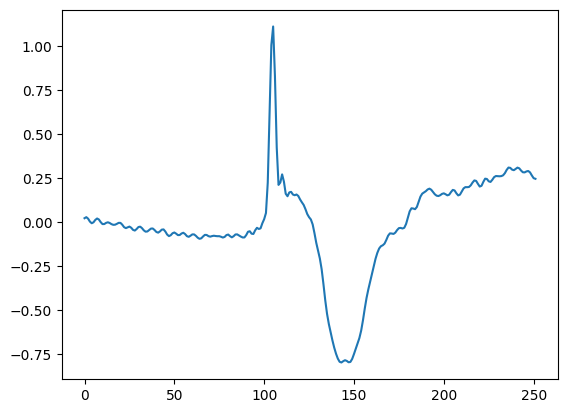

In [ ]:
plt.plot(x_test.transpose()[:,1])
plt.show()

###**Latidos clase 2** 

In [ ]:
# Find the index of the value 3 in the array
index = np.where(y_test == 2)

print(index[0]) 

[   10    11    15 ... 32292 32294 32299]


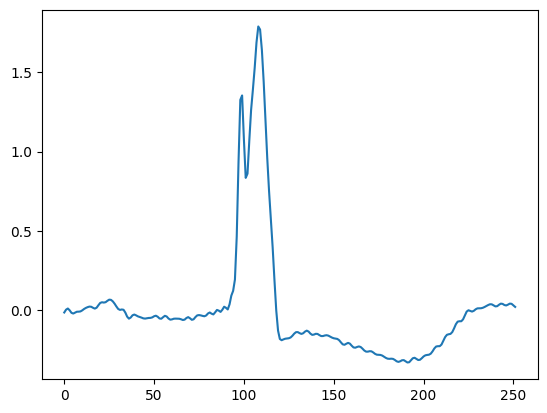

In [ ]:
plt.plot(x_test.transpose()[:,11])
plt.show()

# **Resultados paper IEEE**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=2, metric='manhattan')
knn.fit(pd.DataFrame(x_train), y_train.flatten())
#score = cross_val_score(knn, pd.DataFrame(x_validation), y_validation.flatten(), cv=10)
y_pred = knn.predict(x_test)
cm= confusion_matrix(y_test, y_pred)
print(cm)
acc = accuracy_score(y_test, y_pred)
print('acc:', acc)

# **EXPERIMENTOS SIN AUTOENCODERS**

## **Funciones**

In [ ]:
def cross_validation_stratified(clf, X_np, y_np, cv):
  skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
  lst_accu_stratified = []
  
  X = X_np.copy()
  X['y'] = y_np
  y = X['y']
  X = X.drop(columns=['y'])

  for train_index, test_index in skf.split(X, y):
      x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
      y_train_fold, y_test_fold = y[train_index], y[test_index]
      clf.fit(x_train_fold, y_train_fold)
      lst_accu_stratified.append(clf.score(x_test_fold, y_test_fold))
  return np.asarray(lst_accu_stratified) 

In [ ]:
def trainAndAccuracy(clf,params,x_train, y_train, x_test, y_test):

  if (clf is 'knn'):
    model = KNNClassifierCustom(params)
    y_train_ravel=y_train.values.ravel()
    model.fit(x_train, y_train_ravel)
    y_pred_knn = model.predict(x_test) 
    acc_knn= model.score(x_test,y_test)
    return(acc_knn,y_pred_knn)

  elif (clf is 'svm'):
    start_time = time.time()
    svc = SVC(kernel='linear')
    svc.fit(x_train, y_train)
    y_pred_test_svm=svc.predict(x_test) 
    cm_svm= confusion_matrix(y_test, y_pred_test_svm)
    acc_test_svm= svc.score(x_test,y_test)
    end_time = time.time()
    elapsed_time = (end_time - start_time)/60
    elapsed_time_svm=round(elapsed_time, 2) 

    return(acc_test_svm,cm_svm,elapsed_time_svm)
    
  elif (clf is 'lda'):
    start_time = time.time()
    lda = LinearDiscriminantAnalysis()
    lda.fit(x_train, y_train)
    y_pred_test_lda=lda.predict(x_test) 
    cm_lda= confusion_matrix(y_test, y_pred_test_lda)
    acc_test_lda= lda.score(x_test,y_test)
    end_time = time.time()
    elapsed_time = (end_time - start_time)/60
    elapsed_time_lda=round(elapsed_time, 2) 

    return(acc_test_lda,cm_lda,elapsed_time_lda)

  elif (clf is 'gnb'):
    start_time = time.time()
    gnb = GaussianNB()
    gnb.fit(x_train, y_train)
    y_pred_test_gnb=gnb.predict(x_test) 
    cm_gnb= confusion_matrix(y_test, y_pred_test_gnb)
    acc_test_gnb= gnb.score(x_test,y_test)
    end_time = time.time()
    elapsed_time = (end_time - start_time)/60
    elapsed_time_gnb=round(elapsed_time, 2) 

    return(acc_test_gnb,cm_gnb,elapsed_time_gnb)

  elif (clf is 'dt'):
    start_time = time.time()
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(x_train, y_train)
    y_pred_test_dt=dt.predict(x_test) 
    cm_dt= confusion_matrix(y_test, y_pred_test_dt)
    acc_test_dt= dt.score(x_test,y_test)
    end_time = time.time()
    elapsed_time = (end_time - start_time)/60
    elapsed_time_dt=round(elapsed_time, 2) 

    return(acc_test_dt,cm_dt,elapsed_time_dt)
  elif (clf is 'dt_custom'):
    start_time = time.time()
    dt=DecisionTreesClassifierCustom(params)
    model.fit(x_train, y_train)
    y_pred_test_svm=model.predict(x_test) 
    acc_test_dt_custom= model.score(x_test,y_test)
    cm_dt_custom= confusion_matrix(y_test, y_pred_test_dt)
    end_time = time.time()
    elapsed_time = (end_time - start_time)/60
    elapsed_time_dt_custom=round(elapsed_time, 2) 
    return(acc_test_dt_custom,cm_dt_custom,elapsed_time_dt_custom)

  elif (clf is 'lr'):
    start_time = time.time()
    lr = LogisticRegression(random_state=42)
    lr.fit(x_train, y_train)
    y_pred_test_lr=lr.predict(x_test) 
    cm_lr= confusion_matrix(y_test, y_pred_test_lr)
    acc_test_lr= lr.score(x_test,y_test)
    end_time = time.time()
    elapsed_time = (end_time - start_time)/60
    elapsed_time_lr=round(elapsed_time, 2) 

    return(acc_test_lr,cm_lr,elapsed_time_lr)



    

<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:50: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:62: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:74: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:50: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:62: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:74: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-5-d1f9baa80f5f>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (clf is 'knn'):
<ipython-input-5-d1f9baa

## **Clasificadores**

### **SVM**

In [ ]:
print("----RESULTADOS PARA EL CLASIFICADOR SVM----")
clf= 'svm'
acc_test_svm,cm_svm,elapsed_time_svm=trainAndAccuracy(clf,x_train, y_train,x_test, y_test)
#print("cm: ", cm_svm)
print("  ")
print("----------")
print("SVM SIN STRATIFIED ")
print("----------")
print("acc_test_svm: ",acc_test_svm)
print("Tiempo transcurrido: ", elapsed_time_svm, "minutos")

print("  ")
print("----------")
print("SVM STRATIFIED ")
print("----------")
##  STRATIFIED
start_time = time.time()
svc = SVC(kernel='linear')
score = cross_validation_stratified(svc, pd.DataFrame(x_test), y_test.flatten(), cv=10)
score_mean_svc=score.mean()
end_time = time.time()
elapsed_time = (end_time - start_time)/60
elapsed_time_svm_stratified=round(elapsed_time, 10) 
print("score: ",score)
print("score mean: ", score_mean_svc)
print("Tiempo transcurrido: ", elapsed_time_svm_stratified, "minutos")


----RESULTADOS PARA EL CLASIFICADOR SVM----


NameError: ignored

 **busqueda de parametros**

In [ ]:
y_train2=y_train.ravel()
# Define the hyperparameters to test
C_values = [0.01, 0.1, 1, 10, 100]
kernel_types = ['linear', 'poly', 'rbf', 'sigmoid']
gamma_values = ['scale', 'auto']

# Perform hyperparameter tuning
best_score = 0
for C in C_values:
    for kernel in kernel_types:
        for gamma in gamma_values:
            svm = SVC(C=C, kernel=kernel, gamma=gamma)
            svm.fit(x_train, y_train2)
            score = svm.score(x_train, y_train2)
            if score > best_score:
                best_score = score
                best_svm = svm

# Evaluate the performance of the best model on the test set
test_score = best_svm.score(x_test, y_test)
print("Best hyperparameters: C={}, kernel={}, gamma={}".format(best_svm.C, best_svm.kernel, best_svm.gamma))
print("Training score: ", best_score)
print("Test score: ", test_score)


Best hyperparameters: C=100, kernel=rbf, gamma=scale
Training score:  0.9997747471024286
Test score:  0.7787572074501182


### **Linear Discriminant Analysis**

In [ ]:
y_train2=y_train.ravel()
print("----RESULTADOS PARA EL CLASIFICADOR LDA----")
clf= 'lda'
acc_test_lda,cm_lda,elapsed_time_lda=trainAndAccuracy(clf,x_train, y_train2,x_test, y_test)
#print("cm: ", cm_lda)
print("  ")
print("----------")
print("LDA SIN STRATIFIED ")
print("----------")
print("acc_test_svm: ",acc_test_lda)
print("Tiempo transcurrido: ", elapsed_time_lda, "minutos")

print("  ")
print("----------")
print("LDA STRATIFIED ")
print("----------")
##  STRATIFIED
start_time = time.time()
lda = LinearDiscriminantAnalysis()
score_lda = cross_validation_stratified(lda, pd.DataFrame(x_test), y_test.flatten(), cv=10)
score_mean_lda=score_lda.mean()
end_time = time.time()
elapsed_time = (end_time - start_time)/60
elapsed_time_lda_stratified=round(elapsed_time, 2) 
print("score: ",score_lda)
print("score mean: ", score_mean_lda)
print("Tiempo transcurrido: ", elapsed_time_lda_stratified, "minutos")

----RESULTADOS PARA EL CLASIFICADOR LDA----
  
----------
LDA SIN STRATIFIED 
----------
acc_test_svm:  0.8480524329033061
Tiempo transcurrido:  0.1 minutos
  
----------
LDA STRATIFIED 
----------
score:  [0.95085027 0.94711738 0.94919121 0.9529241  0.95872226 0.94835096
 0.95084007 0.94876582 0.94980295 0.94482473]
score mean:  0.9501389735956621
Tiempo transcurrido:  0.66 minutos


**busqueda de parametros**

### **Gaussian NB**

In [ ]:
y_train2=y_train.ravel()
print("----RESULTADOS PARA EL CLASIFICADOR GNB----")
clf= 'gnb'
acc_test_gnb,cm_gnb,elapsed_time_gnb=trainAndAccuracy(clf,x_train, y_train2,x_test, y_test)
print("  ")
print("----------")
print("GNB SIN STRATIFIED ")
print("----------")
print("acc_test_gnb: ",acc_test_gnb)
print("Tiempo transcurrido: ", elapsed_time_gnb, "minutos")

print("  ")
print("----------")
print("GNB STRATIFIED ")
print("----------")
##  STRATIFIED
start_time = time.time()
gnb = GaussianNB()
score_gnb = cross_validation_stratified(gnb, pd.DataFrame(x_test), y_test.flatten(), cv=10)
score_mean_gnb=score_gnb.mean()
end_time = time.time()
elapsed_time = (end_time - start_time)/60
elapsed_time_gnb_stratified=round(elapsed_time, 2) 
print("score: ",score_gnb)
print("score mean: ", score_mean_gnb)
print("Tiempo transcurrido: ", elapsed_time_gnb_stratified, "minutos")

----RESULTADOS PARA EL CLASIFICADOR GNB----
  
----------
GNB SIN STRATIFIED 
----------
acc_test_gnb:  0.8591695358194715
Tiempo transcurrido:  0.03 minutos
  
----------
GNB STRATIFIED 
----------
score:  [0.89693073 0.88905019 0.89983409 0.88656159 0.89815391 0.88301182
 0.8828044  0.88550093 0.89690935 0.88591579]
score mean:  0.8904672811323955
Tiempo transcurrido:  0.11 minutos


**busqueda de parametros**

In [ ]:
y_train2=y_train.ravel()
# Define the hyperparameters to test
var_smoothing_values = [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]
priors_values = [None, [0.2, 0.8], [0.5, 0.5]]
#tol_values = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]

# Initialize variables to store the best hyperparameters and their corresponding score
best_var_smoothing = 0
best_priors = None
#best_tol = 0
best_score = 0

# Loop over the different values of the hyperparameters
for var_smoothing in var_smoothing_values:
    for priors in priors_values:
        #for tol in tol_values:
     
            # Create a Gaussian Naive Bayes classifier object with the current values of the hyperparameters
            #gnb = GaussianNB(var_smoothing=var_smoothing, priors=priors, tol=tol)
            gnb = GaussianNB(var_smoothing=var_smoothing, priors=priors)
                             
            # Train the model on the training set
            gnb.fit(x_train, y_train2)
        
            # Evaluate the performance of the model on the test set
            score = gnb.score(x_test, y_test)
        
            # Check if the current values of the hyperparameters resulted in a better score than the best score so far
            if score > best_score:
                best_score = score
                best_var_smoothing = var_smoothing
                best_priors = priors
                #best_tol = tol
            
# Train a Gaussian Naive Bayes classifier with the best values of the hyperparameters on the full training set
#best_gnb = GaussianNB(var_smoothing=best_var_smoothing, priors=best_priors, tol=best_tol)
best_gnb = GaussianNB(var_smoothing=best_var_smoothing, priors=best_priors)
best_gnb.fit(x_train, y_train2)

# Evaluate the performance of the best model on the test set
test_score = best_gnb.score(x_test, y_test)

# Print the best values of the hyperparameters and their score on the training data
#print(f"Best hyperparameters: var_smoothing={best_var_smoothing}, priors={best_priors}, tol={best_tol}")
print(f"Best hyperparameters: var_smoothing={best_var_smoothing}, priors={best_priors}")
print(f"Best score: {best_score}")

# Print the test score of the best model
print(f"Test score: {test_score}")


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best hyperparameters: var_smoothing=1e-05, priors=None
Best score: 0.8591902766831211
Test score: 0.8591902766831211


### **Decision Tree Classifier**

In [ ]:
y_train2=y_train.ravel()
print("----RESULTADOS PARA EL CLASIFICADOR DT----")
clf= 'dt'
acc_test_dt,cm_dt,elapsed_time_dt=trainAndAccuracy(clf,x_train, y_train2,x_test, y_test)
print("  ")
print("----------")
print("DT SIN STRATIFIED ")
print("----------")
print("acc_test_dt: ",acc_test_dt)
print("Tiempo transcurrido: ", elapsed_time_dt, "minutos")

print("  ")
print("----------")
print("DT STRATIFIED ")
print("----------")
##  STRATIFIED
start_time = time.time()
dt = DecisionTreeClassifier(random_state=42)
score_dt = cross_validation_stratified(dt, pd.DataFrame(x_test), y_test.flatten(), cv=10)
score_mean_dt=score_dt.mean()
end_time = time.time()
elapsed_time = (end_time - start_time)/60
elapsed_time_dt_stratified=round(elapsed_time, 2) 
print("score: ",score_dt)
print("score mean: ", score_mean_dt)
print("Tiempo transcurrido: ", elapsed_time_dt_stratified, "minutos")

----RESULTADOS PARA EL CLASIFICADOR DT----
  
----------
DT SIN STRATIFIED 
----------
acc_test_dt:  0.7858505828182686
Tiempo transcurrido:  1.48 minutos
  
----------
DT STRATIFIED 
----------
score:  [0.98631273 0.98776441 0.98527582 0.98589797 0.98630989 0.98568762
 0.98382078 0.98402821 0.98589504 0.98465049]
score mean:  0.9855642968070271
Tiempo transcurrido:  8.67 minutos


**busqueda de parametros**

In [ ]:
# Define a list of hyperparameters to test
criterion_values = ['gini', 'entropy']
max_depth_values = [2, 4, 6, 8]

# Initialize variables to store the best hyperparameters and their corresponding score
best_criterion = ''
best_max_depth = 0
best_score = 0

# Loop over the different combinations of hyperparameters
for criterion in criterion_values:
    for max_depth in max_depth_values:
        
        dtc = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)
        dtc.fit(x_train, y_train)
        score = dtc.score(x_test, y_test)
        if score > best_score:
            best_score = score
            best_criterion = criterion
            best_max_depth = max_depth
            
# Train a decision tree classifier with the best hyperparameters on the full training set
best_tree = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_max_depth)
best_tree.fit(x_train, y_train)

# Evaluate the performance of the best model on the test set
test_score = best_tree.score(x_test, y_test)

# Print the best hyperparameters and their score on the training data
print(f"Best hyperparameters: criterion={best_criterion}, max_depth={best_max_depth}")
print(f"Best score: {best_score}")

# Print the test score of the best model
print(f"Test score: {test_score}")

Best hyperparameters: criterion=gini, max_depth=6
Best score: 0.8330982702119716
Test score: 0.8276226822084871


### **Logistic Regression**

In [ ]:
y_train2=y_train.ravel()
print("----RESULTADOS PARA EL CLASIFICADOR LR----")
clf= 'lr'
acc_test_lr,cm_lr,elapsed_time_lr=trainAndAccuracy(clf,x_train, y_train2,x_test, y_test)
print("  ")
print("----------")
print("LR SIN STRATIFIED ")
print("----------")
print("acc_test_lr: ",acc_test_lr)
print("Tiempo transcurrido: ", elapsed_time_lr, "minutos")

print("  ")
print("----------")
print("DT STRATIFIED ")
print("----------")
##  STRATIFIED
start_time = time.time()
lr = LogisticRegression(random_state=42)
score_lr= cross_validation_stratified(lr, pd.DataFrame(x_test), y_test.flatten(), cv=2)
score_mean_lr=score_dt.mean()
end_time = time.time()
elapsed_time = (end_time - start_time)/60
elapsed_time_lr_stratified=round(elapsed_time, 2) 
print("score: ",score_lr)
print("score mean: ", score_mean_lr)
print("Tiempo transcurrido: ", elapsed_time_lr_stratified, "minutos")

----RESULTADOS PARA EL CLASIFICADOR LR----


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  
----------
LR SIN STRATIFIED 
----------
acc_test_lr:  0.8479072468577592
Tiempo transcurrido:  0.12 minutos
  
----------
DT STRATIFIED 
----------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


score:  [0.96486498 0.96179533]
score mean:  0.9855642968070271
Tiempo transcurrido:  0.14 minutos


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**busqueda de parametros**

In [ ]:
y_train2=y_train.ravel()
# Define the hyperparameters to test
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
#penalties = ['l1', 'l2', 'elasticnet', 'none']
#penalties = ['l2',  'none']
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# Perform hyperparameter tuning
best_score = 0
for C in C_values:
    #for penalty in penalties:
    for solver in solvers:
          #lr = LogisticRegression(C=C, penalty=penalty, solver=solver)
          lr = LogisticRegression(C=C, solver=solver)
          lr.fit(x_train, y_train2)
          score = lr.score(x_train, y_train2)
          if score > best_score:
              best_score = score
              best_lr = lr

# Evaluate the performance of the best model on the test set
test_score = best_lr.score(x_test, y_test)
#print("Best hyperparameters: C={}, penalty={}, solver={}".format(best_lr.C, best_lr.penalty, best_lr.solver))
print("Best hyperparameters: C={}, solver={}".format(best_lr.C, best_lr.solver))
print("Training score: ", best_score)
print("Test score: ", test_score)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef

Best hyperparameters: C=100, solver=liblinear
Training score:  0.9868534217962894
Test score:  0.8412286887626


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


texto en negrita# **myAutoencoder**

In [ ]:
#https://www.kaggle.com/code/devavratatripathy/ecg-anomaly-detection-using-autoencoders
import json

class myAutoencoder():
    def __init__(self, encoding_dim,input_dim,loss, optimizer, capas=[], verbose=2):
        self.encoding_dim = encoding_dim
        self.input_dim = input_dim
        self.loss = loss
        self.optimizer = optimizer
        self.autoencoder = None
        self.capas = capas
        self.verbose = verbose

####### Funcion para generar el modelo
    def generate_model2(self):
        # this is our input placeholder
        input_layer = Input(shape=(self.input_dim,))

        cont = 0
        
        encoding_layers = []
        decoding_layers = []        
        for i in range(len(self.capas)):
            if i == 0:
                encoding_layers.append(Dense(self.capas[i], activation='relu')(input_layer))
            else:
                encoding_layers.append(Dense(self.capas[i], activation='relu')(encoding_layers[i-1]))
        #latent_layer = Dense(self.encoding_dim, activation='relu')(encoding_layers[-1])
        if len(encoding_layers):
          latent_layer = Dense(self.encoding_dim, activation='sigmoid')(encoding_layers[-1])
        else:
          latent_layer = Dense(self.encoding_dim, activation='sigmoid')(input_layer)

        # Decoder Layers
        for i in range(len(self.capas)-1, -1, -1):
            if i == len(self.capas)-1:
                decoding_layers.append(Dense(self.capas[i], activation='relu')(latent_layer))
            else:
                decoding_layers.append(Dense(self.capas[i], activation='relu')(decoding_layers[-1]))
        
        if len(encoding_layers):
          output_layer = Dense(self.input_dim, activation='sigmoid')(decoding_layers[-1])
        else:
          output_layer = Dense(self.input_dim, activation='sigmoid')(latent_layer)

        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

####### Funcion para entrenar el autoencoder
    def fit(self, x_train, x_test, epochs, batch_size, shuffle=True, optimizer='adam', loss='mae'):
      self.autoencoder.compile(optimizer=optimizer, loss=loss)
      return self.autoencoder.fit(x_train, x_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  shuffle=shuffle,
                  verbose = self.verbose,
                  callbacks=[CALLBACK_ES],
                  validation_data=(x_test, x_test))
      
####### Funcion para obtener el codificador      
    def get_encoder(self):
      num_layer = len(self.capas) + 1
      return Model(self.autoencoder.input, self.autoencoder.layers[num_layer].output)

####### Funcion para obtener el decodificador
    def get_decoder(self):
      decoder_input = Input(shape=(self.encoding_dim,))
      cont = 0
      activation= 'relu'
      for capa in reversed(self.capas):
        if cont == 0:
            decoded = Dense(capa, activation=activation)(decoder_input)
        else:
            decoded = Dense(capa, activation=activation)(decoded)
        cont = cont + 1


      if cont ==0:
        decoded = Dense(self.input_dim, activation='sigmoid')(decoder_input)
      else:
        decoded = Dense(self.input_dim, activation='sigmoid')(decoded)

      decoder = Model(decoder_input, decoded)
      encoder = self.get_encoder()
      for i in range(1, len(decoder.layers)):
        decoder.layers[i].set_weights(self.autoencoder.layers[len(encoder.layers)+i-1].get_weights())

      return decoder

####### Funcion para guardar el modelo
    def save(self, nameFile):
      self.autoencoder.save(nameFile)
      
      data = { 'encoding_dim': self.encoding_dim,
              'input_dim':   self.input_dim,
              'loss':  self.loss,
              'optimizer': self.optimizer,
              'capas': self.capas
      } 
      json_string = json.dumps(data)
      file_name = nameFile + '.json'
      with open(file_name, 'w') as outfile:
        json.dump(json_string, outfile)

####### Funcion para cargar el modelo
    def load(self, nameFile):
      self.autoencoder = keras.models.load_model(nameFile, compile=False) 
      json_file = nameFile + '.json'
      with open(json_file, 'r') as f:
        aux_str = json.load(f)
      aux= json.loads(aux_str)
    
      self.encoding_dim = aux['encoding_dim']
      self.input_dim = aux['input_dim']
      self.loss = aux['loss']
      self.optimizer = aux['optimizer']
      self.capas = aux['capas']




*texto en cursiva*# **myAutoencoder_finne_tunning**

In [ ]:
class myAutoencoder_finne_tunning():
    def __init__(self, autoencoder):
        self.autoencoder = autoencoder
        self.model_no_trainable_sofmax_trainable  = None
        self.model_trainable_sofmax_trainable  = None
        self.autoencoder_ft = None
        

def grid_fit(x_train, x_test, encoding_dim,input_dim,loss, optimizer,epochs,batch_size, capas=[], plot=True, verbose = 2):

    #autoencoder = generate_model(encoding_dim,input_dim,loss, optimizer)
    for capa in capas:
      autoencoder = myAutoencoder(encoding_dim=encoding_dim,input_dim=input_dim,loss=loss, optimizer=optimizer, capas=capa, verbose=verbose)
      # Funcion generar modelo
      autoencoder.generate_model2()

      best_loss = 1
      best_model, best_history = None, None
      for i in range(len(batch_size)):
        # Funcion compilar el autoencoder
        history  = autoencoder.fit(x_train, x_test, epochs, batch_size=batch_size[i],shuffle=True, loss=loss, optimizer=optimizer)

        if plot:
          plt.plot(history.history['loss'])
          plt.plot(history.history['val_loss'])
          plt.title('model loss: '+ str(batch_size[i]) + ' ' + str(capa))
          plt.ylabel('loss')
          plt.xlabel('epoch')
          plt.legend(['train', 'test'], loc='upper left')
          plt.show()
          
        if history.history['loss'][-1] < best_loss:
          best_loss = history.history['loss'][-1]
          best_model = autoencoder
          best_history = history
          if verbose==2:
            print(capa, batch_size[i], epochs)
    return best_model, best_history

def box_plot(df_orig):
    # Establecer colores para cada valor único de 'capas'
    df = df_orig.copy()
    #df['capas'] = [','.join(map(str, l)) for l in df['capas']]
    df['capas']=df['capas'].values.astype(str)
    fig, ax = plt.subplots()
    #f = plt.figure()
    fig.set_figwidth(12)
    fig.set_figheight(3)    
    df.boxplot(column=['rmse'], by=['capas', 'encoding_dim' ], ax=ax)
    
    # Agregar etiquetas de ejes
    ax.set_xlabel('Configuración')
    ax.set_ylabel('RMSE')
    ax.set_title('')
    plt.suptitle('')
    plt.xticks(rotation=90)
    plt.show()


# **AUTOENCODERS**

In [ ]:
import json

class myAutoencoder():
    def __init__(self, encoding_dim,input_dim,loss, optimizer, capas=[], verbose=2):
        self.encoding_dim = encoding_dim
        self.input_dim = input_dim
        self.loss = loss
        self.optimizer = optimizer
        self.autoencoder = None
        self.capas = capas
        self.verbose = verbose

    def generate_model2(self):
        # this is our input placeholder
        input_layer = Input(shape=(self.input_dim,))

        cont = 0
        
        encoding_layers = []
        decoding_layers = []        
        for i in range(len(self.capas)):
            if i == 0:
                encoding_layers.append(Dense(self.capas[i], activation='relu')(input_layer))
            else:
                encoding_layers.append(Dense(self.capas[i], activation='relu')(encoding_layers[i-1]))
        #latent_layer = Dense(self.encoding_dim, activation='relu')(encoding_layers[-1])
        if len(encoding_layers):
          latent_layer = Dense(self.encoding_dim, activation='sigmoid')(encoding_layers[-1])
        else:
          latent_layer = Dense(self.encoding_dim, activation='sigmoid')(input_layer)

        # Decoder Layers
        for i in range(len(self.capas)-1, -1, -1):
            if i == len(self.capas)-1:
                decoding_layers.append(Dense(self.capas[i], activation='relu')(latent_layer))
            else:
                decoding_layers.append(Dense(self.capas[i], activation='relu')(decoding_layers[-1]))
        
        if len(encoding_layers):
          output_layer = Dense(self.input_dim, activation='sigmoid')(decoding_layers[-1])
        else:
          output_layer = Dense(self.input_dim, activation='sigmoid')(latent_layer)

        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)
    
    def get_encoder(self):
      num_layer = len(self.capas) + 1
      return Model(self.autoencoder.input, self.autoencoder.layers[num_layer].output)

    def get_decoder(self):
      decoder_input = Input(shape=(self.encoding_dim,))
      cont = 0
      activation= 'relu'
      for capa in reversed(self.capas):
        if cont == 0:
            decoded = Dense(capa, activation=activation)(decoder_input)
        else:
            decoded = Dense(capa, activation=activation)(decoded)
        cont = cont + 1


      if cont ==0:
        decoded = Dense(self.input_dim, activation='sigmoid')(decoder_input)
      else:
        decoded = Dense(self.input_dim, activation='sigmoid')(decoded)

      decoder = Model(decoder_input, decoded)
      encoder = self.get_encoder()
      for i in range(1, len(decoder.layers)):
        decoder.layers[i].set_weights(self.autoencoder.layers[len(encoder.layers)+i-1].get_weights())

      return decoder
 

    def fit(self, x_train, x_test, epochs, batch_size, shuffle=True, optimizer='adam', loss='mae'):
      self.autoencoder.compile(optimizer=optimizer, loss=loss)
      return self.autoencoder.fit(x_train, x_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  shuffle=shuffle,
                  verbose = self.verbose,
                  callbacks=[CALLBACK_ES],
                  validation_data=(x_test, x_test))

    def save(self, nameFile):
      self.autoencoder.save(nameFile)
      
      data = { 'encoding_dim': self.encoding_dim,
              'input_dim':   self.input_dim,
              'loss':  self.loss,
              'optimizer': self.optimizer,
              'capas': self.capas
      } 
      json_string = json.dumps(data)
      file_name = nameFile + '.json'
      with open(file_name, 'w') as outfile:
        json.dump(json_string, outfile)

    def load(self, nameFile):
      self.autoencoder = keras.models.load_model(nameFile, compile=False) 
      json_file = nameFile + '.json'
      with open(json_file, 'r') as f:
        aux_str = json.load(f)
      aux= json.loads(aux_str)
    
      self.encoding_dim = aux['encoding_dim']
      self.input_dim = aux['input_dim']
      self.loss = aux['loss']
      self.optimizer = aux['optimizer']
      self.capas = aux['capas']



In [ ]:
class myAutoencoder_finne_tunning():
    def __init__(self, autoencoder):
        self.autoencoder = autoencoder
def grid_fit(x_train, x_test, encoding_dim,input_dim,loss, optimizer,epochs,batch_size, capas=[], plot=True, verbose = 2):

    #autoencoder = generate_model(encoding_dim,input_dim,loss, optimizer)
    for capa in capas:
      autoencoder = myAutoencoder(encoding_dim=encoding_dim,input_dim=input_dim,loss=loss, optimizer=optimizer, capas=capa, verbose=verbose)
      autoencoder.generate_model2()

      best_loss = 1
      best_model, best_history = None, None
      for i in range(len(batch_size)):
        history  = autoencoder.fit(x_train, x_test, epochs, batch_size=batch_size[i],shuffle=True, loss=loss, optimizer=optimizer)

        if plot:
          plt.plot(history.history['loss'])
          plt.plot(history.history['val_loss'])
          plt.title('model loss: '+ str(batch_size[i]) + ' ' + str(capa))
          plt.ylabel('loss')
          plt.xlabel('epoch')
          plt.legend(['train', 'test'], loc='upper left')
          plt.show()
          
        if history.history['loss'][-1] < best_loss:
          best_loss = history.history['loss'][-1]
          best_model = autoencoder
          best_history = history
          if verbose==2:
            print(capa, batch_size[i], epochs)
    return best_model, best_history
def box_plot(df_orig):
    # Establecer colores para cada valor único de 'capas'
    df = df_orig.copy()
    #df['capas'] = [','.join(map(str, l)) for l in df['capas']]
    df['capas']=df['capas'].values.astype(str)
    fig, ax = plt.subplots()
    #f = plt.figure()
    fig.set_figwidth(12)
    fig.set_figheight(3)    
    df.boxplot(column=['rmse'], by=['capas', 'encoding_dim' ], ax=ax)
    
    # Agregar etiquetas de ejes
    ax.set_xlabel('Configuración')
    ax.set_ylabel('RMSE')
    ax.set_title('')
    plt.suptitle('')
    plt.xticks(rotation=90)
    plt.show()

# **Busqueda mejores parametros (minimo MSE)**

In [ ]:
input_dim = 252
encoding_dim_list =  [ 190 ] #100 , 125, 150, 180, 185,
epochs_list= [300] #30,
batch_size_list= [[16]] #, ,[32],[64], [512]
capas_list =  [[[]]]
#capas_list = [ [[252,252,252]], [[252,252,252,252]], [[252,252,252,252,252]] ] #, [[100]], [[200]], [[]], [[100]], [[200]], [[200,175]]
#loss='mae'
loss='mse'
#loss = 'categorical_crossentropy'
#optimizer='sgd'
optimizer='adam'

y_train_oh = np.eye(len(np.unique(y_train.flatten())))[y_train.flatten()-1]
y_test_oh = np.eye(len(np.unique(y_test.flatten())))[y_test.flatten()-1]


instance_num = 1
best_rmse = 1000
ejecuciones = []
for capas in capas_list :
  for encoding_dim in encoding_dim_list:
    for epochs in epochs_list:
      for batch_size in batch_size_list:
        model, history=grid_fit(x_train_norm, x_test_norm, encoding_dim,input_dim,loss, optimizer,epochs,batch_size, capas, plot= False, verbose = 0)
        enc = model.get_encoder()
        dec = model.get_decoder()
        ## Encoded_datapoints  --> enc.predict(x_test_norm)
        ## Decoded_datapoints -->
        dec_x_test_norm = dec.predict(enc.predict(x_test_norm))
        rmse = mean_squared_error(x_test_norm, dec_x_test_norm, squared=False)
        mae = mean_squared_error(x_test_norm, dec_x_test_norm, squared=True)   
        params = {'capas':capas[0], 'encoding_dim': encoding_dim, 'epochs': epochs, 'batch_size': batch_size[0], 'encoding_dim': encoding_dim, 'rmse': rmse, 'mae':mae}
        ejecuciones.append(params)
        if best_rmse > rmse:
          best_rmse = rmse
          best_model = model
          best_history = history
          print('Mejores parametros:', params)
          

df = pd.DataFrame.from_records(ejecuciones)
print(df)

now = datetime.now().strftime("%d-%m-%Y_%H-%M")
nameFile = 'autoencoder_prueba_acc_' + str(best_rmse) + '_'
best_model.save(path_models+nameFile+now+'.h5')
df.to_csv(path_models+nameFile+now+'.csv', sep=';')


1507/1507 [==============================] - 2s 1ms/step
Mejores parametros: {'capas': [], 'encoding_dim': 190, 'epochs': 300, 'batch_size': 16, 'rmse': 0.007103755, 'mae': 5.607656e-05}
  capas  encoding_dim  epochs  batch_size      rmse       mae
0    []           190     300          16  0.007104  0.000056


# **Cargamos el mejor modelo**

In [ ]:
autoencoder1 = myAutoencoder(encoding_dim=None, input_dim=None, loss=None, optimizer=None)
autoencoder1.load(path_models+'autoencoder_prueba_acc_0.006655296_09-05-2023_15-52.h5')
best_model = autoencoder1
enc = best_model.get_encoder()
dec = best_model.get_decoder()

autoencoder2 = myAutoencoder(encoding_dim=None, input_dim=None, loss=None, optimizer=None)
autoencoder2.load(path_models+'autoencoder_prueba_acc_0.0067506186_05-05-2023_12-24.h5')
best_model_2 = autoencoder2
enc_2 = best_model_2.get_encoder()
dec_2 = best_model_2.get_decoder()

###**Latido clase 1** 

**Espacio latente, encoded datapoints**

1/1 [==============================] - 0s 58ms/step


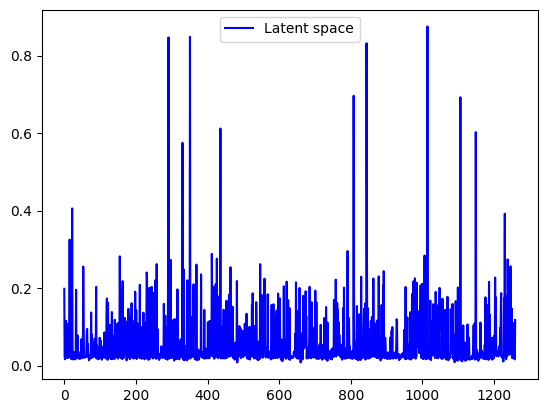

In [ ]:
latido = 1
ins_enc = enc.predict(np.array([x_test_norm[latido]]))

plt.plot(ins_enc[0], 'b')
plt.legend(labels=['Latent space'])
plt.show()

**Reconstruccion**

1/1 [==============================] - 0s 65ms/step


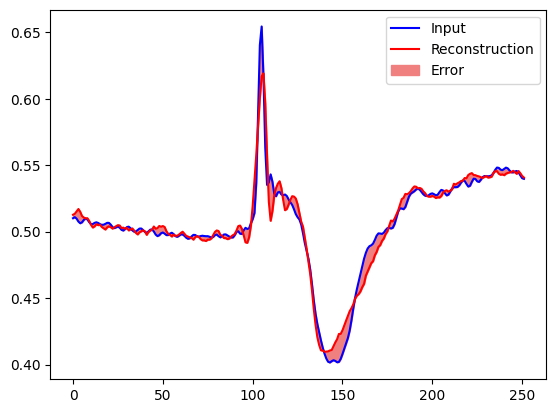

In [ ]:
new_instance = dec.predict(enc.predict(np.array([x_test_norm[latido]])))
plot_diference(x_test_norm[latido], new_instance[0])

###**Latido clase 2** 

**Espacio latente, encoded datapoints**

1/1 [==============================] - 0s 70ms/step


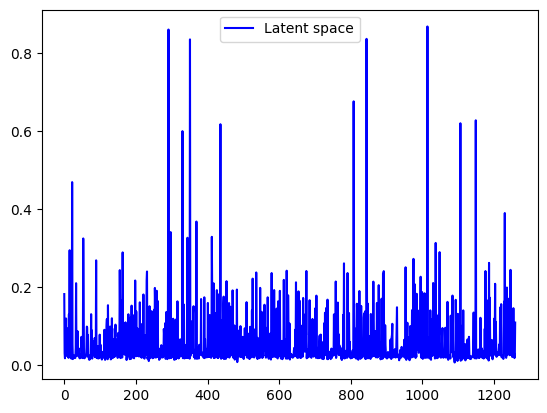

In [ ]:
latido2 = 11
ins_enc2 = enc.predict(np.array([x_test_norm[latido2]]))

plt.plot(ins_enc2[0], 'b')
plt.legend(labels=['Latent space'])
plt.show()

1/1 [==============================] - 0s 46ms/step


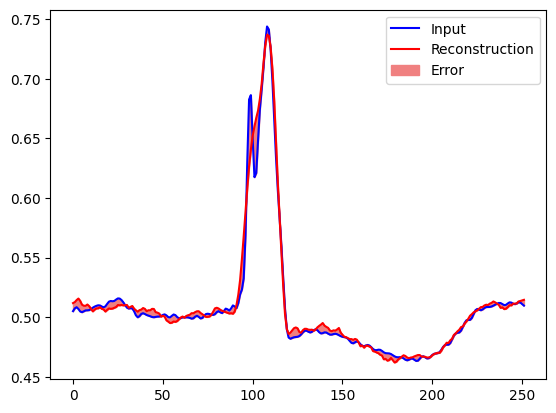

In [ ]:
new_instance = dec.predict(enc.predict(np.array([x_test_norm[latido2]])))
plot_diference(x_test_norm[latido2], new_instance[0])

# **Analisis ejecuciones para busqueda de mejores parametros**

In [ ]:
data = pd.read_csv(path_models+'autoencoder_prueba_completo.csv', delimiter=';')
metric_min = 'rmse'
min_rmse = data[metric_min].min()

print(data.sort_values(by=[metric_min]).head(10))

#print(data[data['capas']== '[252]'])

data[data[metric_min]== min_rmse]

     Unnamed: 0 capas  encoding_dim  epochs  batch_size      rmse       mae
341         338    []          1260   10000          16  0.006655  0.000050
340         337    []          1260    1000          16  0.006735  0.000053
72           72    []          1008     100          16  0.006751  0.000051
338         335    []          1008   10000          16  0.006780  0.000052
149         149    []           195     100           8  0.006823  0.000053
336         133    []          1008     300          16  0.006823  0.000053
68           68    []           504     100          16  0.006904  0.000053
140         140    []          2016     100          16  0.006933  0.000058
343         340    []          2016    1000          16  0.007011  0.000056
36           36    []           225     100          16  0.007023  0.000055


,Unnamed: 0,capas,encoding_dim,epochs,batch_size,rmse,mae
341,338,[],1260,10000,16,0.006655,0.00005


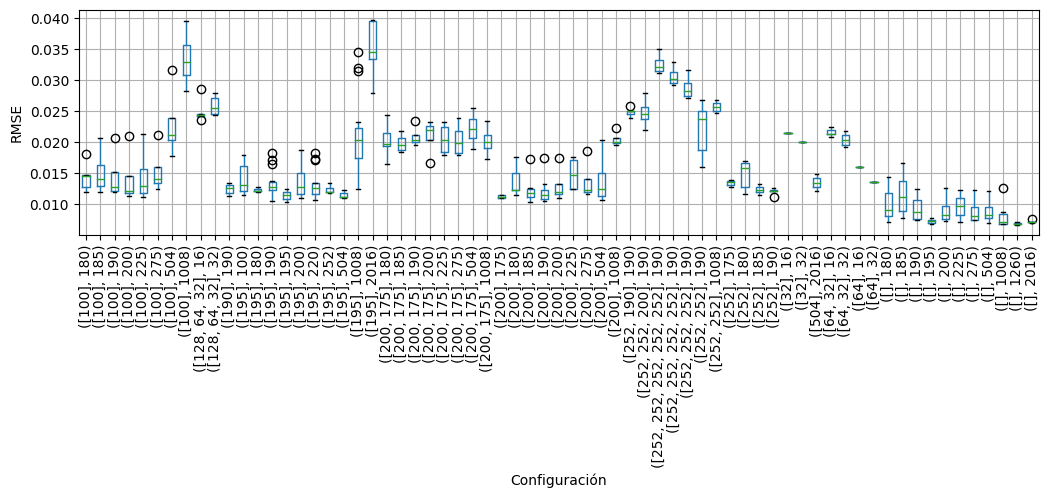

In [ ]:
data = pd.read_csv(path_models+'autoencoder_prueba_completo.csv', delimiter=';')
#print(data)
box_plot(data)

# **EXPERIMENTOS**

## **Experimento 1.**
Comparativa entrenando con datos reales vs entrenando con los datos en el espacio latente (obtenidos del encoder)

In [ ]:
models = [] 
models.append(KNeighborsClassifier(n_neighbors=2, metric='manhattan'))
models.append(SVC(kernel= 'linear', random_state=1))
models.append(SVC(kernel= 'rbf', random_state=1))
models.append(GaussianNB())
models.append(DecisionTreeClassifier())
models.append(LinearDiscriminantAnalysis())

## x_train encoded_datapoints 
x_train_enc = pd.DataFrame(enc.predict(x_train_norm))
## x_test encoded_datapoints 
x_test_enc = enc.predict(x_test_norm)
for clf in models:    
    # Entrenamiento con los datos en el espacio latente
    clf.fit(x_train_enc, y_train.flatten())
    y_pred_enc = clf.predict(x_test_enc)
    acc_enc = accuracy_score(y_test, y_pred_enc)
    cm_enc= confusion_matrix(y_test, y_pred_enc)

    # Entrenamiento con datos reales
    clf.fit(x_train, y_train.flatten())
    y_pred = clf.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    cm= confusion_matrix(y_test, y_pred)

    print('accuracy:', acc, ' accuracy_enc:', acc_enc, ' mejora:', acc_enc-acc)
    print('cm enc: ',cm_enc)
    print('cm : ',cm)

    

1507/1507 [==============================] - 4s 3ms/step
accuracy: 0.8898037914298751  accuracy_enc: 0.839196084124943  mejora: -0.05060770730493214  cm:  [[35902  1313]
 [ 6440  4559]]
accuracy: 0.8262123034803169  accuracy_enc: 0.9056290703944913  mejora: 0.07941676691417432  cm:  [[36198  1017]
 [ 3533  7466]]
accuracy: 0.8387190442610031  accuracy_enc: 0.8921682498859252  mejora: 0.05344920562492217  cm:  [[36343   872]
 [ 4327  6672]]
accuracy: 0.8591695358194715  accuracy_enc: 0.878437798149915  mejora: 0.01926826233044343  cm:  [[34373  2842]
 [ 3019  7980]]
accuracy: 0.7697349317625586  accuracy_enc: 0.7807483303604762  mejora: 0.011013398597917612  cm:  [[32983  4232]
 [ 6339  4660]]
accuracy: 0.8480524329033061  accuracy_enc: 0.8451487119923674  mejora: -0.002903720910938712  cm:  [[36083  1132]
 [ 6334  4665]]


## **Experimento 2.**
Comparativa entrenando con datos reales vs entrenando con los datos reconstruidos (obtenidos del autoencoder (encoder + decoder))

In [ ]:
models = [] 
models.append(KNeighborsClassifier(n_neighbors=2, metric='manhattan'))
models.append(SVC(kernel= 'linear', random_state=1))
models.append(SVC(kernel= 'rbf', random_state=1))
models.append(GaussianNB())
models.append(DecisionTreeClassifier())
models.append(LinearDiscriminantAnalysis())

## x_train decoded_datapoints 
x_train_enc = pd.DataFrame(dec.predict(enc.predict(x_train_norm)))
## x_test decoded_datapoints 
x_test_enc = dec.predict(enc.predict(x_test_norm))
for clf in models:    
    # Entrenamiento con los datos de train del decodificador (datos reconstruidos)
    clf.fit(x_train_enc, y_train.flatten())
    # Predice con los datos de test del decodificador (datos reconstruidos)
    y_pred_enc = clf.predict(x_test_enc)
    acc_enc = accuracy_score(y_test, y_pred_enc)

    # Entrenamiento datos reales
    clf.fit(x_train, y_train.flatten())
    y_pred = clf.predict(x_test)
    acc = accuracy_score(y_test, y_pred)

    print('accuracy:', acc, ' accuracy_enc:', acc_enc, ' mejora:', acc_enc-acc)

    cm= confusion_matrix(y_test, y_pred_enc)

1507/1507 [==============================] - 8s 5ms/step
accuracy: 0.8898037914298751  accuracy_enc: 0.8680051437341851  mejora: -0.021798647695689954
accuracy: 0.8262123034803169  accuracy_enc: 0.8638154892769735  mejora: 0.03760318579665656
accuracy: 0.8387190442610031  accuracy_enc: 0.836209399759406  mejora: -0.0025096445015970748
accuracy: 0.8591695358194715  accuracy_enc: 0.8562243331812337  mejora: -0.0029452026382378316
accuracy: 0.7640519351225785  accuracy_enc: 0.7959928651429046  mejora: 0.03194093002032605
accuracy: 0.8480524329033061  accuracy_enc: 0.8894511967478326  mejora: 0.041398763844526454


## **Experimento 3.**

1.   Aumentamos los latidos de la clase minoritaria generando latidos sinteticos con el autoencoder
2.   Comparativa entrenando con datos reales vs entrenando con los datos reales + sinteticos en el espacio latente  (obtenidos del encoder) 

In [ ]:
def generate_sintetic_data(x_train_norm, y_train, enc, dec, class_value=2, frac=0.2, plot=True):
  x_train_norm_pd = pd.DataFrame(x_train_norm)
  # los datos de x_train con el valor de y train
  x_train_norm_pd['y'] = y_train
  if plot:
    print("PLOT x_train_norm_pd ")
    x_train_norm_pd['y'].plot.hist()
    plt.show()
  # se seleccionan los latidos de la class_value (clase minoritaria)
  x_train_norm_pd_2 = x_train_norm_pd[x_train_norm_pd['y'] == class_value] 
  print("shape 1: ", x_train_norm_pd_2.shape)
  # se obtienen muestras de latidos de x train
  x_train_norm_pd_2_sample = x_train_norm_pd_2.sample(frac=frac, replace=True, random_state=1)
  print("shape 2: ", x_train_norm_pd_2_sample.shape)
  # Se elimina la variable y 
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample.loc[:, x_train_norm_pd_2_sample.columns != 'y']
  # Se obtiene los latidos sinteticos --> reconstruccion de muestras
  x_train_norm_pd_2_sample_sintetico =  pd.DataFrame(dec.predict(enc.predict(x_train_norm_pd_2_sample_sintetico)))
  x_train_norm_pd_2_sample_sintetico['y'] = class_value
  # latidos reales + latidos sinteticos reconstruidos
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)  
  if plot:  
    print("PLOT x_train_norm_pd_2_sample_sintetico")
    x_train_norm_pd_2_sample_sintetico['y'].plot.hist()
    plt.show()
  # Se genera el y_train
  y_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico['y']
  # Se elimina la columna y de la variable x train
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.loc[:, x_train_norm_pd_2_sample_sintetico.columns != 'y']
  return x_train_norm_pd_2_sample_sintetico, y_train_norm_pd_2_sample_sintetico


In [ ]:
models = [] 
models.append(KNeighborsClassifier(n_neighbors=2, metric='manhattan'))
models.append(SVC(kernel= 'linear', random_state=1))
models.append(SVC(kernel= 'rbf', random_state=1))
models.append(GaussianNB())
models.append(DecisionTreeClassifier())
models.append(LinearDiscriminantAnalysis())

x_train_enc = pd.DataFrame(enc.predict(x_train_norm_pd_2_sample_sintetico)) 
x_test_enc = enc.predict(x_test_norm)
for clf in models:   
    # Entrenamiento con los datos del codificador 
    clf.fit(x_train_enc, y_train_norm_pd_2_sample_sintetico) 
    y_pred_enc = clf.predict(x_test_enc)
    acc_enc = accuracy_score(y_test, y_pred_enc)

    # Entrenamiento datos reales
    clf.fit(x_train, y_train.flatten())
    y_pred = clf.predict(x_test)
    acc = accuracy_score(y_test, y_pred)

    print('accuracy:', acc, ' accuracy_enc:', acc_enc, ' mejora:', acc_enc-acc)

    cm= confusion_matrix(y_test, y_pred_enc)

1507/1507 [==============================] - 3s 2ms/step
accuracy: 0.8898037914298751  accuracy_enc: 0.8468494628116314  mejora: -0.042954328618243665
accuracy: 0.8262123034803169  accuracy_enc: 0.8944912266146763  mejora: 0.06827892313435935
accuracy: 0.8387190442610031  accuracy_enc: 0.8913593562035923  mejora: 0.052640311942589224
accuracy: 0.8591695358194715  accuracy_enc: 0.8786037250591114  mejora: 0.01943418923963991
accuracy: 0.757725971709462  accuracy_enc: 0.7841083502717053  mejora: 0.026382378562243347
accuracy: 0.8480524329033061  accuracy_enc: 0.8451279711287178  mejora: -0.0029244617745882717


In [ ]:

x_train_norm_pd_2_sample_sintetico, y_train_norm_pd_2_sample_sintetico = generate_sintetic_data(x_train_norm, 
                                                                                                y_train, 
                                                                                                enc, dec, class_value=2, frac=0.9, plot=True) 
x_train_norm_pd_2_sample_sintetico, y_train_norm_pd_2_sample_sintetico = generate_sintetic_data(x_train_norm_pd_2_sample_sintetico, 
                                                                                                y_train_norm_pd_2_sample_sintetico, 
                                                                                                enc_2, 
                                                                                                dec_2, class_value=2, frac=0.9, plot=True)   

**Pruebas**

In [ ]:
  x_train_norm_pd_2_sample_sintetico, y_train_norm_pd_2_sample_sintetico = generate_sintetic_data(x_train_norm, y_train, enc, dec, class_value=2, frac=0.9, plot=False)
  print("------") 
  x_train_norm_pd_2_sample_sintetico, y_train_norm_pd_2_sample_sintetico = generate_sintetic_data(x_train_norm, y_train, enc, dec, class_value=2, frac=0.5, plot=False) 
  print("------") 
  x_train_norm_pd_2_sample_sintetico, y_train_norm_pd_2_sample_sintetico = generate_sintetic_data(x_train_norm, y_train, enc, dec, class_value=2, frac=0.1, plot=False) 
                                                                                                
                                                                                                

shape 1:  (3608, 253)
shape 2:  (3247, 253)
102/102 [==============================] - 0s 3ms/step
------
shape 1:  (3608, 253)
shape 2:  (1804, 253)
25/57 [============>.................] - ETA: 0s

<ipython-input-53-3caef1299185>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


57/57 [==============================] - 0s 2ms/step
------
shape 1:  (3608, 253)
shape 2:  (361, 253)
 1/12 [=>............................] - ETA: 0s

<ipython-input-53-3caef1299185>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


12/12 [==============================] - 0s 4ms/step


<ipython-input-53-3caef1299185>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


## **Experimento 4.**

1.   Aumentamos los latidos de la clase minoritaria generando latidos sinteticos con el autoencoder
2.   Comparativa entrenando con datos reales vs entrenando con los datos reales + sinteticos en el espacio real  

In [ ]:
models = [] 
models.append(KNeighborsClassifier(n_neighbors=2, metric='manhattan'))
models.append(SVC(kernel= 'linear', random_state=1))
models.append(SVC(kernel= 'rbf', random_state=1))
models.append(GaussianNB())
models.append(DecisionTreeClassifier())
models.append(LinearDiscriminantAnalysis())


## x_train  sinteticos decoded_datapoints **RECONSTRUIDOS**
x_train_norm_pd_2_sample_sintetico_enc = dec.predict(enc.predict(x_train_norm_pd_2_sample_sintetico))
## x_test decoded_datapoints **RECONSTRUIDOS**
x_test_enc = dec.predict(enc.predict(x_test_norm))
for clf in models:    
    # Entrenamiento con los datos de sinteticos train del decodificador (datos reconstruidos)
    clf.fit(x_train_norm_pd_2_sample_sintetico_enc, y_train_norm_pd_2_sample_sintetico)
    # Predice con los datos de test del decodificador (datos reconstruidos)
    y_pred_enc = clf.predict(x_test_enc)
    acc_enc = accuracy_score(y_test, y_pred_enc)

    # Entrenamiento datos reales
    clf.fit(x_train, y_train.flatten())
    y_pred = clf.predict(x_test)
    acc = accuracy_score(y_test, y_pred)

    print('accuracy:', acc, ' accuracy_enc:', acc_enc, ' mejora:', acc_enc-acc)

    cm= confusion_matrix(y_test, y_pred_enc)

1507/1507 [==============================] - 3s 2ms/step
accuracy: 0.8898037914298751  accuracy_enc: 0.8730866553283279  mejora: -0.016717136101547236
accuracy: 0.8262123034803169  accuracy_enc: 0.9156469075372299  mejora: 0.08943460405691295
accuracy: 0.8387190442610031  accuracy_enc: 0.8131040776537936  mejora: -0.02561496660720952
accuracy: 0.8591695358194715  accuracy_enc: 0.8573650806819596  mejora: -0.0018044551375119289
accuracy: 0.7783216493134774  accuracy_enc: 0.7581822707097523  mejora: -0.020139378603725056
accuracy: 0.8480524329033061  accuracy_enc: 0.8866304392914921  mejora: 0.03857800638818598


## **Experimento 5**
Demostracion reduccion de datos entrenamiento en knn reduce precisión

In [ ]:
models = [] 
models.append(KNeighborsClassifier(n_neighbors=2, metric='manhattan'))
models.append(SVC(kernel= 'linear', random_state=1))
models.append(SVC(kernel= 'rbf', random_state=1))
models.append(GaussianNB())
models.append(DecisionTreeClassifier())
models.append(LinearDiscriminantAnalysis())


x_train_norm_samples =  pd.DataFrame(x_train_norm)
x_train_norm_samples['y'] = y_train

for f_samples in [0.1, 0.2, 0.5, 0.7]:
  print('------ samples: ',f_samples, ' --------------')
  aux_train = x_train_norm_samples.sample(frac=f_samples, random_state=1)
  aux_X_train = aux_train.loc[:, aux_train.columns != 'y']
  aux_y_train = aux_train.loc[:, aux_train.columns == 'y']
  
  x_train_enc = pd.DataFrame(enc.predict(aux_X_train))
  x_test_completo_enc = enc.predict(x_test_completo_norm)
  for clf in models:    
      clf.fit(x_train_enc, aux_y_train['y'].ravel())
      y_pred_enc = clf.predict(x_test_completo_enc)
      acc_enc = accuracy_score(y_test_completo, y_pred_enc)

      clf.fit(aux_X_train, aux_y_train['y'].ravel())
      y_pred = clf.predict(x_test_completo)
      acc = accuracy_score(y_test_completo, y_pred)

      print('accuracy:', acc, ' accuracy_enc:', acc_enc, ' mejora:', acc_enc-acc)


## **Experimento 6.**

1.   Repeticion del experimento 3 probando diferentes valoresde la fracción de datos que se pretende muestrear
2.   Se realiza para el calsificador SVC lineal

In [ ]:
#for frac_value in frac_values:
frac_values =[0.1, 0.2, 0.5, 0.9, 1.0,1.5,2.0,2.5,3,4]
acc_values=[]


## x_test decoded_datapoints **RECONSTRUIDOS**
x_test_enc = dec.predict(enc.predict(x_test_norm))

for f_samples in frac_values:
  x_train_norm_pd_2_sample_sintetico, y_train_norm_pd_2_sample_sintetico = generate_sintetic_data(x_train_norm, y_train, enc, dec, class_value=2, frac=f_samples, plot=False)  
  
  ## x_train  sinteticos decoded_datapoints **RECONSTRUIDOS**
  x_train_norm_pd_2_sample_sintetico_enc = dec.predict(enc.predict(x_train_norm_pd_2_sample_sintetico))

  #print("shape: ",x_train_norm_pd_2_sample_sintetico.shape)
  svc = SVC(kernel='linear')
  svc.fit(x_train_norm_pd_2_sample_sintetico_enc, y_train_norm_pd_2_sample_sintetico)
  y_pred_sintetico = svc.predict(x_test_enc)
  acc = accuracy_score(y_test, y_pred_sintetico)
  acc_values.append(acc)
  print("acc: ", acc)
  #return acc_values

   1/1538 [..............................] - ETA: 32s

<ipython-input-20-c777c3533cb4>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


1538/1538 [==============================] - 4s 3ms/step
acc:  0.8639399344588709
23/23 [==============================] - 0s 3ms/step


<ipython-input-20-c777c3533cb4>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


1549/1549 [==============================] - 3s 2ms/step
acc:  0.8651843862778447
   1/1583 [..............................] - ETA: 33s

<ipython-input-20-c777c3533cb4>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


1583/1583 [==============================] - 3s 2ms/step
acc:  0.8713444227817646
   1/1628 [..............................] - ETA: 35s

<ipython-input-20-c777c3533cb4>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


1628/1628 [==============================] - 3s 2ms/step
acc:  0.8832911602439125
  25/1639 [..............................] - ETA: 3s 

<ipython-input-20-c777c3533cb4>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


1639/1639 [==============================] - 3s 2ms/step
acc:  0.8865059941095947
   1/1696 [..............................] - ETA: 34s

<ipython-input-20-c777c3533cb4>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


1696/1696 [==============================] - 3s 2ms/step
acc:  0.8996764425270668
   1/1752 [..............................] - ETA: 38s

<ipython-input-20-c777c3533cb4>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


1752/1752 [==============================] - 3s 2ms/step
acc:  0.9075994524411997
282/282 [==============================] - 1s 2ms/step


<ipython-input-20-c777c3533cb4>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


1808/1808 [==============================] - 3s 2ms/step
acc:  0.9122039241714025
   1/1865 [..............................] - ETA: 37s

<ipython-input-20-c777c3533cb4>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


1865/1865 [==============================] - 4s 2ms/step
acc:  0.9131580038992824
451/451 [==============================] - 1s 2ms/step


<ipython-input-20-c777c3533cb4>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


1978/1978 [==============================] - 4s 2ms/step
acc:  0.9084498278508317


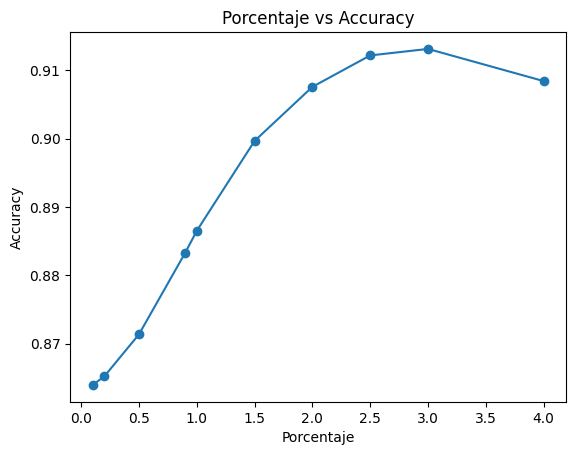

In [ ]:
plt.plot(frac_values, acc_values, marker='o')

# Configurar los ejes y el título
plt.xlabel('Porcentaje')
plt.ylabel('Accuracy')
plt.title('Porcentaje vs Accuracy')

plt.show()

In [ ]:
acc_values

[0.8639399344588709,
 0.8651843862778447,
 0.8713444227817646,
 0.8832911602439125,
 0.8865059941095947,
 0.8996764425270668,
 0.9075994524411997,
 0.9122039241714025,
 0.9131580038992824,
 0.9084498278508317]

## **Experimento 7.**

1.   Repeticion del experimento 3 probando diferentes valoresde la fracción de datos que se pretende muestrear
2.   Se realiza para el calsificador KNN

In [ ]:
#for frac_value in frac_values:
frac_values =[0.1, 0.2, 0.5, 0.9, 1.0,1.5,2.0,2.5,3,4]
acc_values_knn=[]

## x_test decoded_datapoints **RECONSTRUIDOS**
x_test_enc = dec.predict(enc.predict(x_test_norm))

for f_samples in frac_values:
  x_train_norm_pd_2_sample_sintetico, y_train_norm_pd_2_sample_sintetico = generate_sintetic_data(x_train_norm, y_train, enc, dec, class_value=2, frac=f_samples, plot=False)  
  
  ## x_train  sinteticos decoded_datapoints **RECONSTRUIDOS**
  x_train_norm_pd_2_sample_sintetico_enc = dec.predict(enc.predict(x_train_norm_pd_2_sample_sintetico))

  #print("shape: ",x_train_norm_pd_2_sample_sintetico.shape)
  knn = KNeighborsClassifier(n_neighbors=2, metric='manhattan')
  knn.fit(x_train_norm_pd_2_sample_sintetico_enc, y_train_norm_pd_2_sample_sintetico)
  y_pred_sintetico = knn.predict(x_test_enc)
  acc_knn = accuracy_score(y_test, y_pred_sintetico)
  acc_values_knn.append(acc_knn)
  #print("acc: ", acc)
 

12/12 [==============================] - 0s 7ms/step


<ipython-input-20-c777c3533cb4>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


23/23 [==============================] - 0s 3ms/step


<ipython-input-20-c777c3533cb4>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


57/57 [==============================] - 0s 2ms/step


<ipython-input-20-c777c3533cb4>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


   1/1628 [..............................] - ETA: 42s

<ipython-input-20-c777c3533cb4>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


   1/1639 [..............................] - ETA: 36s

<ipython-input-20-c777c3533cb4>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


170/170 [==============================] - 0s 2ms/step


<ipython-input-20-c777c3533cb4>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


226/226 [==============================] - 0s 2ms/step


<ipython-input-20-c777c3533cb4>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


   1/1808 [..............................] - ETA: 39s

<ipython-input-20-c777c3533cb4>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


   1/1865 [..............................] - ETA: 39s

<ipython-input-20-c777c3533cb4>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


   1/1978 [..............................] - ETA: 42s

<ipython-input-20-c777c3533cb4>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_norm_pd_2_sample_sintetico = x_train_norm_pd_2_sample_sintetico.append(x_train_norm_pd)


1978/1978 [==============================] - 4s 2ms/step


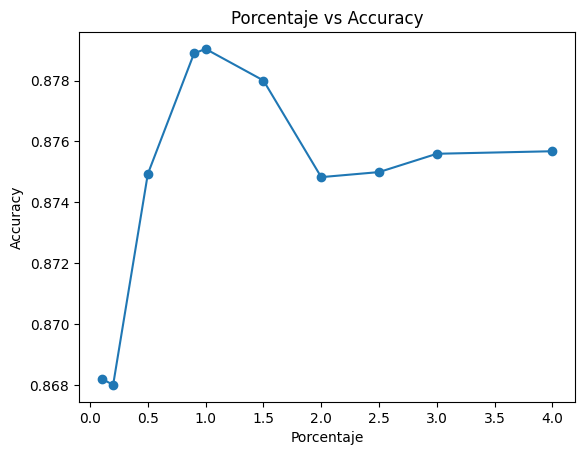

In [ ]:
plt.plot(frac_values, acc_values_knn, marker='o')

# Configurar los ejes y el título
plt.xlabel('Porcentaje')
plt.ylabel('Accuracy')
plt.title('Porcentaje vs Accuracy')

plt.show()

In [ ]:
acc_values_knn

[0.8682125523706807,
 0.8680051437341851,
 0.8749325921931389,
 0.8788940971502054,
 0.8790392831957523,
 0.8780022400132742,
 0.8748288878748911,
 0.8749948147840876,
 0.8755962998299249,
 0.8756792632845232]